<a href="https://colab.research.google.com/github/ekvirika/WalmartRecruiting/blob/main/notebooks/model_experiment_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn

# Set up Kaggle API
!pip install kaggle

In [3]:

# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:

# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [5]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [6]:
!pip install dagshub mlflow --quiet


# Experiment 1

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature
import warnings
warnings.filterwarnings('ignore')


In [8]:
! pip install optuna

In [9]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# stores = pd.read_csv('stores.csv')
# features = pd.read_csv('features.csv')

In [10]:
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# # Original Weekly Sales
# axs[0].plot(train['Weekly_Sales'], label='Weekly_Sales', color='blue')
# axs[0].set_title('Original Weekly Sales')
# axs[0].legend()

# # Rolling Average with window=4
# axs[1].plot(train['Weekly_Sales_rolling_4'], label='Rolling Mean (4 weeks)', color='orange')
# axs[1].set_title('Rolling Average - Window 4')
# axs[1].legend()

# # Rolling Average with window=13
# axs[2].plot(train['Weekly_Sales_rolling_13'], label='Rolling Mean (13 weeks)', color='green')
# axs[2].set_title('Rolling Average - Window 13')
# axs[2].legend()

# # Rolling Average with window=52
# axs[3].plot(train['Weekly_Sales_rolling_52'], label='Rolling Mean (52 weeks)', color='red')
# axs[3].set_title('Rolling Average - Window 52')
# axs[3].legend()

# plt.tight_layout()
# plt.show()


In [11]:
import mlflow
from dagshub import dagshub_logger
import os

# Set tracking URI manually
mlflow.set_tracking_uri("https://dagshub.com/ekvirika/WalmartRecruiting.mlflow")

# Use your DagsHub credentials
os.environ["MLFLOW_TRACKING_USERNAME"] = "ekvirika"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "0adb1004ddd4221395353efea2d8ead625e26197"

# Optional: set registry if you're using model registry
mlflow.set_registry_uri("https://dagshub.com/ekvirika/WalmartRecruiting.mlflow")

🏃 View run XGBoost_Data_Loading at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0/runs/69aabc48ccf14a59826437050ea624c8
🧪 View experiment at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0
🏃 View run XGBoost_Cleaning at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0/runs/953c5c06af58498cb9dcb1c1dbc4df4b
🧪 View experiment at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0
🏃 View run XGBoost_Feature_Engineering at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0/runs/a2dde108c3dd403b815904de18de3a7a
🧪 View experiment at: https://dagshub.com/ekvirika/WalmartRecruiting.mlflow/#/experiments/0
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ WMAE: 1892.65
[0.04673262 0.23820432 0.00473909 0.00300071 0.00190002 0.0026405
 0.0042008  0.00323158 0.00217978 0.0264851  0.01392756 0.22614475
 0.00131012 0.0012725  0.00131724 0.00123085 0.00115285 0.00125891
 0.00878093 

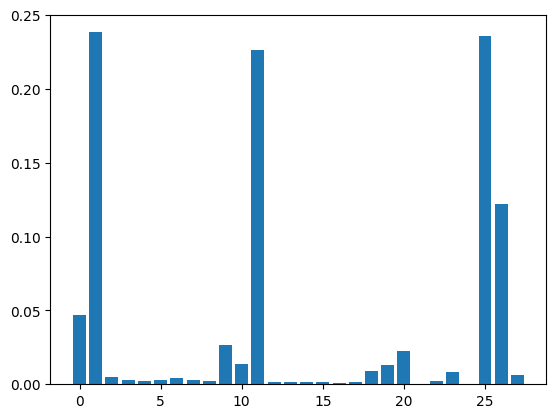

In [16]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import joblib



# ----------------------
# Evaluation Metric (WMAE)
# ----------------------
def weighted_mae(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# ----------------------
# Data Loader
# ----------------------
def load_data():
    with mlflow.start_run(run_name="XGBoost_Data_Loading", nested=True):
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        stores_df = pd.read_csv('stores.csv')
        features_df = pd.read_csv('features.csv')

        df = train_df.merge(features_df, on=['Store', 'Date'], how='inner') \
                     .merge(stores_df, on='Store', how='inner')

        mlflow.log_params({
            "train_shape": train_df.shape,
            "test_shape": test_df.shape,
            "missing_values_train": train_df.isnull().sum().sum(),
            "missing_values_test": test_df.isnull().sum().sum()
        })

        return df

# ----------------------
# Preprocessing
# ----------------------
def preprocess(df):
    with mlflow.start_run(run_name="XGBoost_Cleaning", nested=True):


      df = df.copy()

      # Fix column naming issues
      df["IsHoliday"] = df.pop("IsHoliday_x") if "IsHoliday_x" in df else df["IsHoliday"]
      df.drop(columns=["IsHoliday_y"], errors='ignore', inplace=True)

      # Filter and sort
      df = df[df["Weekly_Sales"] > 0]
      df["Date"] = pd.to_datetime(df["Date"])
      df = df.sort_values(by="Date")

      # Remove outliers
      q_low = df["Weekly_Sales"].quantile(0.01)
      q_high = df["Weekly_Sales"].quantile(0.99)
      df = df[(df["Weekly_Sales"] >= q_low) & (df["Weekly_Sales"] <= q_high)]

      # Lag features
      for lag in [1, 2, 4, 52]:
          df[f"lag_{lag}"] = df.groupby("Store")["Weekly_Sales"].shift(lag)

      # Rolling statistics
      df["rolling_mean_4"] = df.groupby("Store")["Weekly_Sales"].shift(1).rolling(window=4).mean()
      df["rolling_std_4"] = df.groupby("Store")["Weekly_Sales"].shift(1).rolling(window=4).std()

      # Fill missing MarkDowns
      markdown_cols = [col for col in df.columns if "MarkDown" in col]
      df[markdown_cols] = df[markdown_cols].fillna(0)

      # Date features
      df["Year"] = df["Date"].dt.year
      df["Month"] = df["Date"].dt.month
      df["Week"] = df["Date"].dt.isocalendar().week
      df["DayOfWeek"] = df["Date"].dt.dayofweek
      df["IsMonthStart"] = df["Date"].dt.is_month_start.astype(int)
      df["IsMonthEnd"] = df["Date"].dt.is_month_end.astype(int)
      df["Quarter"] = df["Date"].dt.quarter
      df.drop(columns=["Date"], inplace=True)

      mlflow.log_params({"droppped_cols": "IsHoliday_x, IsHoliday_y, Date", "fill_markdown_NaNs": "0"})

      # Drop rows with missing lag/rolling values
      df = df.dropna()

      return df

# ----------------------
# Dynamic Pipeline Builder
# ----------------------
def build_pipeline(X, model=None):
    with mlflow.start_run(run_name="XGBoost_Feature_Engineering", nested=True):

      numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
      categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

      preprocessor = ColumnTransformer(transformers=[
          ("num", SimpleImputer(strategy='mean'), numeric_cols),
          ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
      ])

      if model is None:
          model = XGBRegressor(
              n_estimators=100,
              max_depth=6,
              learning_rate=0.1,
              random_state=42,
              n_jobs=-1
          )

      pipeline = Pipeline([
          ("preprocessor", preprocessor),
          ("model", model)
      ])

      mlflow.log_params({"num_cols": numeric_cols, "cat_cols": categorical_cols,
                        "simple_imputer": "mean", "cat_encoder": "one_hot", "pipeline": pipeline})

      return pipeline

# ----------------------
# Runner
# ----------------------
def run():
    # with mlflow.start_run(run_name="XGBoost_Training"):

      df = load_data()
      df = preprocess(df)

      # Define features and target
      X = df.drop(columns=["Weekly_Sales"])
      y = df["Weekly_Sales"]

      # Split
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.2, random_state=42
      )

      # Store IsHoliday for WMAE
      is_holiday_test = X_test["IsHoliday"].astype(bool).values if "IsHoliday" in X_test.columns else np.zeros_like(y_test)

      # Train
      pipeline = build_pipeline(X_train)

      # Hyperparameter search space
      param_dist = {
          "model__n_estimators": [100, 200, 300],
          "model__max_depth": [3, 6, 9],
          "model__learning_rate": [0.05, 0.1, 0.2],
          "model__subsample": [0.5, 0.7, 1.0],
          "model__colsample_bytree": [0.5, 0.7, 1.0]
      }

      search = RandomizedSearchCV(
          pipeline,
          param_distributions=param_dist,
          n_iter=20,
          cv=3,
          scoring="neg_mean_absolute_error",  # you could also define custom scorer using WMAE if needed
          verbose=2,
          n_jobs=-1,
          random_state=42
      )

      search.fit(X_train, y_train)

      best_model = search.best_estimator_
      y_pred = best_model.predict(X_test)

      # WMAE
      wmae_score = weighted_mae(y_test.values, y_pred, is_holiday_test)
      print(f"✅ WMAE: {wmae_score:.2f}")

      mlflow.log_params(search.best_params_)
      mlflow.log_metric("WMAE", wmae_score)
      # mlflow.xgboost.log_model(best_model, artifact_path="xgb_model")
      joblib.dump(best_model.named_steps["model"], "xgb_model.pkl")
      mlflow.log_artifact("xgb_model.pkl")

      joblib.dump(best_model, "xgb_pipeline.pkl")
      mlflow.log_artifact("xgb_pipeline.pkl")

      # Save feature importance plot as artifact
      fig, ax = plt.subplots()
      xgb_model = best_model.named_steps["model"]
      importances = xgb_model.feature_importances_
      print(importances)
      ax.bar(range(len(importances)), importances)
      plt.savefig("feature_importance.png")
      mlflow.log_artifact("feature_importance.png")


      return best_model

# ----------------------
# Entry Point
# ----------------------
if __name__ == "__main__":
    try:
        with mlflow.start_run(run_name="XGBoost_Training"):
            model = run()
        print("✅ Pipeline executed successfully!")
    except Exception as e:
        print(f"❌ Pipeline failed: {e}")


In [13]:
mlflow.end_run()